In [264]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from keras import regularizers
import matplotlib.pyplot as plt
import sys

2.3.1


In [76]:
data=pd.read_csv('dji30ret.csv',index_col=0)
data.head()
train=data.loc['1987-03-16':'2002-12-31',:]
test=data.loc['2003-01-01':'2009-02-03',:]
names=list(data.columns)

## lag 30 days
for i in range(1,30):
    for j in range(30):
        train[str(names[j])+'_lag_day'+str(i)]=train[names[j]].shift(i)
        test[str(names[j])+'_lag_day'+str(i)]=test[names[j]].shift(i)
#train

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [200]:
def getCube(arg):
    #create X and y
    X=arg
    X_scaled=preprocessing.StandardScaler().fit(train).transform(X)
    X_scaled=pd.DataFrame(X_scaled,index=X.index,columns=X.columns)
    y=pd.DataFrame(arg.loc[:,'AA'])
    y=y.shift(-1)
    y=y.rename(columns={'AA':'t+1'})

    # create 1st cube
    cube=pd.concat([y,X_scaled],axis=1)
    cube=cube.dropna()
    cube['company']='AA'

    # stack vertically
    for i in names[1:]:
        y_=pd.DataFrame(arg[i])
        y_=y_.shift(-1)
        y_=y_.rename(columns={i:'t+1'})
        cube_temp=pd.concat([y_,X_scaled],axis=1)
        cube_temp=cube_temp.dropna()
        cube_temp['company']=i
        cube=cube.append(cube_temp)

    ## get dummies
    dummies=pd.get_dummies(cube['company'])
    cube=pd.concat([cube,dummies],axis=1)
    cube=cube.drop(['company'],axis=1) 
    cube_sorted=cube.sort_index()
    cube_=cube_sorted.iloc[1:,:]
    return cube_

In [228]:
cube_=getCube(train)
cube_test=getCube(test)

# P1

Using the Training Set, fit an a 30-20 Neural Network (i.e. 2 hidden layers, the first with 30 units and
the second with 20 units) to predict the t + 1 individual stock return.

No Dropout Here, instead use a validation set and choose an early stopping in terms of the number of
epochs. 

We will choose an appropriate optimization method and a mini-batch size of 20. 
Then Reportthe mean absolute error for the test set

In [175]:
X_train,y_train=cube_.iloc[:94979,:].iloc[:,1:],cube_.iloc[:94979,:].iloc[:,0]
X_valid,y_valid=cube_.iloc[94980:,:].iloc[:,1:],cube_.iloc[94980:,:].iloc[:,0]

In [176]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation='relu',input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
num_epochs = 100
all_mae_histories = []
es = EarlyStopping(monitor='val_mae',patience=20)

# Build the Keras model (already compiled)
model = build_model()
# Train the model (in monitor mode, verbose=1)
history = model.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=num_epochs, batch_size=20,verbose=0,
                    callbacks=[es]
                   )
mae_history = history.history['val_mae']

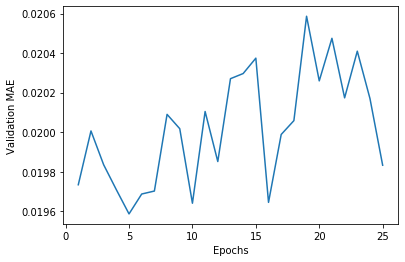

In [104]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [105]:
print('The optimal epoch is: '+str(mae_history.index(min(mae_history))+1))

The optimal epoch is: 5


In [106]:
# get a fresh and compiled model
model = build_model()
# Train it on the entirety of the data.
X_test=cube_test.iloc[:,1:]
y_test=cube_test.iloc[:,0]
X_train=cube_.iloc[:,1:]
y_train=cube_.iloc[:,0]
model.fit(X_train, y_train,
          epochs=5, batch_size=20, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
print('test set mae is: ',test_mae_score)

45089/45089 [==============================] - 1s 23us/step
test set mae is:  0.013882494531571865


# P2

Using the Training Set, we will fit a 15-10-5 Neural Network to predict the t + 1 individual stock return. This
time use a Dropout rate of 0.3 and no validation. Report the mean absolute error for the test set.

In [107]:
def build_model_d():
    model = models.Sequential()
    model.add(layers.Dense(15, activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(layers.Dense(10, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [108]:
# get a fresh and compiled model
model_d = build_model_d()
# Train it on the entirety of the data.
model_d.fit(X_train, y_train,
          epochs=5, batch_size=20, verbose=0)
test_mse_score, test_mae_score = model_d.evaluate(X_test, y_test)
print('test set mae is: ',test_mae_score)

45089/45089 [==============================] - 1s 25us/step
test set mae is:  0.012708804570138454


# P3

fit 15-10-5 Neural Network to predict the t+ 1 individual stock return

No dropout this time but instead use L2 regularization.

Use cross-validation to choose the appropriate regularization parameter

Explain how you performed cross validation to avoid leakage

Report the mean absolute error for the test set.

In [153]:
def build_model_l(k):
    model = models.Sequential()
    model.add(layers.Dense(15, activation='relu',input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l2(k)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [161]:
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=3)
tscv
train_indexs=[]
test_indexs=[]
mae=[]

for k in [0.01,0.1,1,10]:
    print('Now, we are testing k= '+str(k))
    test_mae_scores=[]
    for train_index,test_index in tscv.split(cube_):
        # add a block to avoid 'using today to predict today'
        test_index=test_index[500:]
        print('train:', train_index, '; test:',test_index)
        
        # prepocess the data
        X_train=cube_.iloc[train_index,1:]
        y_train=cube_.iloc[train_index,0]
        X_test=cube_.iloc[test_index,1:]
        y_test=cube_.iloc[test_index,0]
        # get a fresh and compiled model
        model_l = build_model_l(k)
        # Train it on the entirety of the data.
        model_l.fit(X_train, y_train,
                  epochs=1, batch_size=20, verbose=0)
        test_mse_score, test_mae_score = model_l.evaluate(X_test, y_test)
        test_mae_scores.append(round(test_mae_score,5))
    mae_avg=sum(test_mae_scores)/len(test_mae_scores)
    print('test set mae is: ',mae_avg,'\n\n')
    mae.append(mae_avg)


Now, we are testing k= 0.01
train: [    0     1     2 ... 29684 29685 29686] ; test: [30187 30188 30189 ... 59368 59369 59370]
29184/29184 [==============================] - 1s 24us/step
train: [    0     1     2 ... 59368 59369 59370] ; test: [59871 59872 59873 ... 89052 89053 89054]
29184/29184 [==============================] - 1s 24us/step
train: [    0     1     2 ... 89052 89053 89054] ; test: [ 89555  89556  89557 ... 118736 118737 118738]
29184/29184 [==============================] - 1s 23us/step
test set mae is:  0.014836666666666665 


Now, we are testing k= 0.1
train: [    0     1     2 ... 29684 29685 29686] ; test: [30187 30188 30189 ... 59368 59369 59370]
29184/29184 [==============================] - 1s 23us/step
train: [    0     1     2 ... 59368 59369 59370] ; test: [59871 59872 59873 ... 89052 89053 89054]
29184/29184 [==============================] - 1s 24us/step
train: [    0     1     2 ... 89052 89053 89054] ; test: [ 89555  89556  89557 ... 118736 118737 11873

Text(0, 0.5, 'mae')

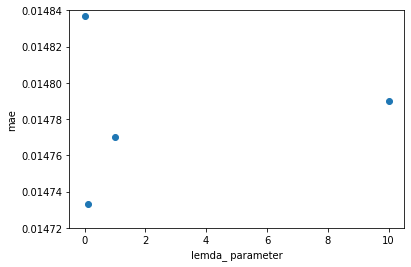

In [171]:
plt.scatter([0.01,0.1,1,10],mae)
plt.ylim(0.01472,0.01484)
plt.xlabel('lemda_ parameter')
plt.ylabel('mae')

As you can notice, optimal regularization hyperparameter is 0.1

In [170]:
# process the data
X_test=cube_test.iloc[:,1:]
y_test=cube_test.iloc[:,0]
X_train=cube_.iloc[:,1:]
y_train=cube_.iloc[:,0]
# get a fresh and compiled model
model_l = build_model_l(0.01)
# Train it on the entirety of the data.
model_l.fit(X_train, y_train,
            epochs=5, batch_size=20, verbose=0) # set 'epochs' back to 5
test_mse_score, test_mae_score = model_l.evaluate(X_test, y_test)
print('test set mae is: ',test_mae_score)

45089/45089 [==============================] - 1s 22us/step
test set mae is:  0.01301301084458828


For TimeSeriesCV, 'No Leakage','No Using Future to Predict Past'
I first sorted DataFrame by ascending index/date, then use 'TimeSeriesSplit' split sorted DataFrame in order to restrain from 'Using Future to Predict Past';

On top of that, I ran the command 'test_index=test_index[500:]' to plug a block between train and test, in order to prevent us from 'Using Today to Predict Today'

Hope I made my point, even though it was loosely explained.

# P4

Using the Training Set, fit 15-10-5 Neural Network to predict the t+ 1 individual stock up/down move (1
for positive return and 0 for negative return).

Again use a Dropout rate of 0.3 and no validation. 
We will Report the classification accuracy for the test set. (Note that this is a classification problem.)

In [238]:
def get_binary_cube(arg):
    y_01=pd.DataFrame(arg['t+1']>=0,index=arg.index)
    y_01=y_01.replace({True:1,False:0})
    cube_binary=pd.concat([y_01,arg.iloc[:,1:]],axis=1)
    return cube_binary

In [239]:
# create binary data
cube_binary=get_binary_cube(cube_)
cube_test_binary=get_binary_cube(cube_test)

In [253]:
def build_model_01():
    model = models.Sequential()
    model.add(layers.Dense(15, activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(layers.Dense(10, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(1, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [281]:
# process the data
X_test=cube_test_binary.iloc[:,1:]
y_test=cube_test_binary.iloc[:,0]
X_train=cube_binary.iloc[:,1:]
y_train=cube_binary.iloc[:,0]
# get a fresh and compiled model
model_01 = build_model_01()
# Train it on the entirety of the data.
model_01.fit(X_train, y_train,
            epochs=5, batch_size=20, verbose=0) # set 'epochs' back to 5
test_loss_score, test_accuracy_score = model_01.evaluate(X_test, y_test)
print('test set accuracy is: ',test_accuracy_score)

45089/45089 [==============================] - 1s 25us/step
test set accuracy is:  0.5133846402168274


Text(0.5, 1.0, 'Prediction: "1/0" vs Data')

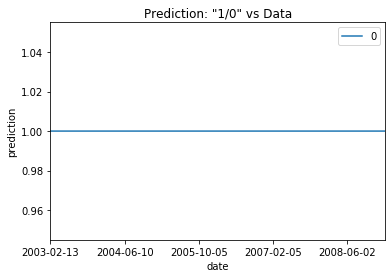

In [282]:
pred=model_01.predict(X_test)
graph=pd.DataFrame(pred,index=X_test.index).plot()
graph.set_xlabel('date')
graph.set_ylabel('prediction')
graph.set_title('Prediction: "1/0" vs Data')

As you can see, the fitted model predicts all test data as '1', there is no '0' at all !

Therefore, these binary datasets failed this NN model very badly; 

# P5

###### QUESTION: 
Compare the mean absolute error of the different estimated models on the Test Set. What are your
conclusions?

#### Conclusion: Dropout/Bagging method outperformed the rest of methods.

Part 1(Vanilla Nets)   mae is 0.01388 '

Part 2(Dropout)        mae is 0.012708'

Part 3(Regularization) mae is 0.012708'

Part 4(Classification) mae is a joke